<a href="https://colab.research.google.com/github/ptl-harsh/QLab_Task/blob/main/P2T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Image Restoration:

####Denoising using DNCNN architecture

In [2]:
#@title Step 1: Mount Google Drive and Install Required Libraries
# Mount Google Drive to access the CBSD68 folder.
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install torch torchvision torchaudio scikit-image


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully u

In [3]:
#@title Step 2: Import Libraries and Set Up Environment
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from PIL import Image

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


In [4]:
#@title Step 3 (Modified): Define the Dataset for CBSD68 with Consistent Image Sizes

# Update the base_dir variable with the correct path to your CBSD68 folder on Google Drive.
base_dir = "/content/drive/MyDrive/IISC_intern_task/CBSD68"

# Use "noisy35" for noisy images and "original_png" for clean images.
noisy_dir = os.path.join(base_dir, "noisy35")
clean_dir = os.path.join(base_dir, "original_png")

# Create a custom PyTorch Dataset to load paired images.
class CBSD68Dataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        """
        noisy_dir: Directory with noisy images.
        clean_dir: Directory with ground truth images (PNG).
        transform: Optional transforms (e.g., resizing, tensor conversion).
        """
        self.noisy_paths = sorted(glob.glob(os.path.join(noisy_dir, "*.png")))
        self.clean_paths = sorted(glob.glob(os.path.join(clean_dir, "*.png")))
        self.transform = transform

        if len(self.noisy_paths) == 0 or len(self.clean_paths) == 0:
            raise ValueError("No images found. Check your directory paths and file extensions.")
        if len(self.noisy_paths) != len(self.clean_paths):
            raise ValueError("Mismatch in number of noisy and clean images.")

    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        # Open the image files using PIL
        noisy_img = Image.open(self.noisy_paths[idx]).convert("RGB")
        clean_img = Image.open(self.clean_paths[idx]).convert("RGB")

        # Apply transforms if provided; otherwise, convert to tensor in [0,1] range.
        if self.transform:
            noisy = self.transform(noisy_img)
            clean = self.transform(clean_img)
        else:
            to_tensor = transforms.ToTensor()
            noisy = to_tensor(noisy_img)
            clean = to_tensor(clean_img)

        return noisy, clean

# Define a transform that resizes all images to a fixed size and then converts them to tensor.
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 (adjust as needed)
    transforms.ToTensor(),          # Convert image to tensor with pixel values in [0,1]
])

# Create the dataset instance
dataset = CBSD68Dataset(noisy_dir, clean_dir, transform=transform)
print("Number of image pairs:", len(dataset))


Number of image pairs: 68


In [5]:
#@title Step 4: Define the DnCNN Model for Image Denoising
# DnCNN uses residual learning to predict the noise; the denoised image is obtained by subtracting the predicted noise from the input.
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17, num_of_features=64):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1  # To preserve image size

        # First layer: Convolution + ReLU (no BatchNorm)
        layers = [nn.Conv2d(channels, num_of_features, kernel_size, padding=padding),
                  nn.ReLU(inplace=True)]

        # Intermediate layers: Convolution + BatchNorm + ReLU
        for _ in range(num_of_layers - 2):
            layers += [nn.Conv2d(num_of_features, num_of_features, kernel_size, padding=padding),
                       nn.BatchNorm2d(num_of_features),
                       nn.ReLU(inplace=True)]

        # Last layer: Convolution (output noise)
        layers.append(nn.Conv2d(num_of_features, channels, kernel_size, padding=padding))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        # Residual learning: subtract predicted noise from input image
        return x - noise

# Initialize the model
model = DnCNN(channels=3, num_of_layers=17, num_of_features=64)
print(model)


DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2

In [8]:
#@title Step 5: Set Up Training Parameters and DataLoader
# Hyperparameters
num_epochs = 40
batch_size = 16
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Epoch [1/40], Loss: 0.025944
Epoch [2/40], Loss: 0.014379
Epoch [3/40], Loss: 0.008653
Epoch [4/40], Loss: 0.007316
Epoch [5/40], Loss: 0.005743
Epoch [6/40], Loss: 0.004771
Epoch [7/40], Loss: 0.004197
Epoch [8/40], Loss: 0.003767
Epoch [9/40], Loss: 0.003585
Epoch [10/40], Loss: 0.003442
Epoch [11/40], Loss: 0.003385
Epoch [12/40], Loss: 0.003260
Epoch [13/40], Loss: 0.003299
Epoch [14/40], Loss: 0.003254
Epoch [15/40], Loss: 0.003206
Epoch [16/40], Loss: 0.003219
Epoch [17/40], Loss: 0.003186
Epoch [18/40], Loss: 0.003173
Epoch [19/40], Loss: 0.003243
Epoch [20/40], Loss: 0.003184
Epoch [21/40], Loss: 0.003240
Epoch [22/40], Loss: 0.003219
Epoch [23/40], Loss: 0.003197
Epoch [24/40], Loss: 0.003218
Epoch [25/40], Loss: 0.003217
Epoch [26/40], Loss: 0.003206
Epoch [27/40], Loss: 0.003236
Epoch [28/40], Loss: 0.003199
Epoch [29/40], Loss: 0.003204
Epoch [30/40], Loss: 0.003188
Epoch [31/40], Loss: 0.003192
Epoch [32/40], Loss: 0.003161
Epoch [33/40], Loss: 0.003176
Epoch [34/40], Loss

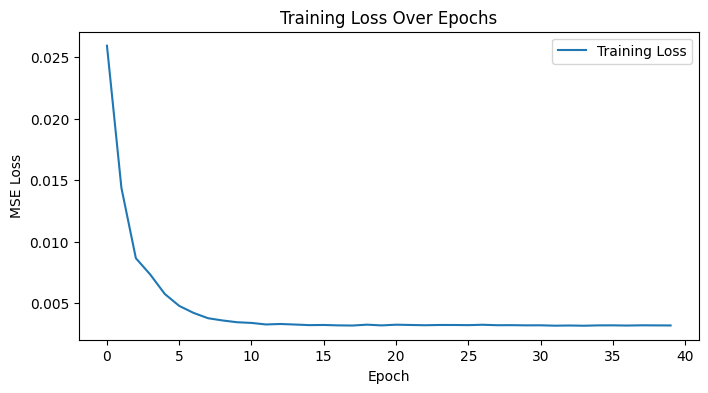

In [9]:
#@title Step 6: Train the DnCNN Model
model.train()
train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (noisy_imgs, clean_imgs) in enumerate(dataloader):
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

# Plot training loss over epochs
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


In [12]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Ensure images are at least 7x7 or set an appropriate win_size
for idx in range(num_eval):
    noisy, clean = dataset[idx]
    denoised = denoise_image(model, noisy)

    noisy_np = tensor_to_img(noisy)
    clean_np = tensor_to_img(clean)
    denoised_np = tensor_to_img(denoised)

    psnr = compare_psnr(clean_np, denoised_np, data_range=255)

    # Fix: Explicitly set win_size if image size is too small
    min_dim = min(clean_np.shape[:2])
    win_size = 7 if min_dim >= 7 else min_dim if min_dim % 2 == 1 else min_dim - 1

    ssim = compare_ssim(clean_np, denoised_np, channel_axis=2, data_range=255, win_size=win_size)

    psnr_list.append(psnr)
    ssim_list.append(ssim)

    print(f"Image {idx+1} - PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

print(f"\nAverage PSNR: {np.mean(psnr_list):.2f}")
print(f"Average SSIM: {np.mean(ssim_list):.4f}")


Image 1 - PSNR: 24.53, SSIM: 0.2940
Image 2 - PSNR: 24.76, SSIM: 0.6737
Image 3 - PSNR: 25.48, SSIM: 0.4413
Image 4 - PSNR: 24.85, SSIM: 0.6467
Image 5 - PSNR: 24.93, SSIM: 0.6272

Average PSNR: 24.91
Average SSIM: 0.5366


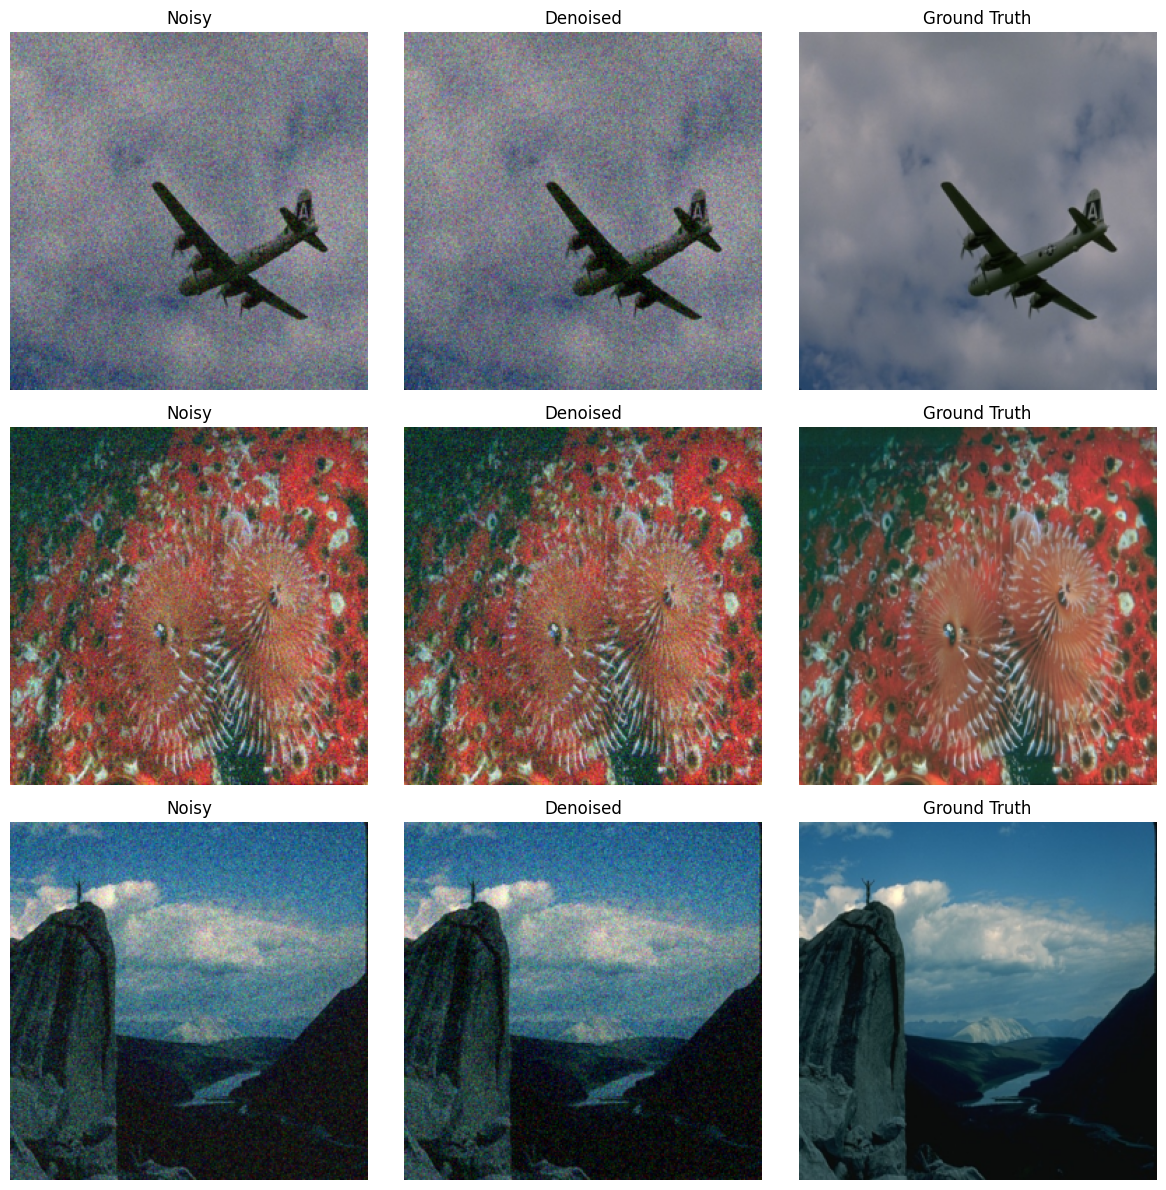

In [13]:
#@title Step 8: Visualize Denoising Results
num_display = 3
plt.figure(figsize=(12, num_display * 4))

for i in range(num_display):
    noisy, clean = dataset[i]
    denoised = denoise_image(model, noisy)

    noisy_np = tensor_to_img(noisy)
    clean_np = tensor_to_img(clean)
    denoised_np = tensor_to_img(denoised)

    # Display the images: Noisy, Denoised, Ground Truth
    plt.subplot(num_display, 3, i * 3 + 1)
    plt.imshow(noisy_np)
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(num_display, 3, i * 3 + 2)
    plt.imshow(denoised_np)
    plt.title("Denoised")
    plt.axis("off")

    plt.subplot(num_display, 3, i * 3 + 3)
    plt.imshow(clean_np)
    plt.title("Ground Truth")
    plt.axis("off")

plt.tight_layout()
plt.show()
